# NISAR Cryosphere ATBD Code Examples and Documentation
---

This notebook serves to illustrate some of the capabilities of the nisardev classes used to implement the NISAR Cryo cal/val notebooks.

In [1]:
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
from urllib import request
from gimpfunc import NASALogin
import matplotlib.pyplot as plt
import panel
import pyproj
import numpy as np
from datetime import datetime
panel.extension() 

## Login for Remote Access

For remote access to data at NSIDC, run these cells to login with your NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details). These cells can skipped if all data are being accessed locally.

In [2]:
myLogin = NASALogin()
myLogin.view()

Row
    [0] ParamMethod(method)
    [1] Column(margin=5, name='Earth Data Login', width=300)
        [0] StaticText(value='<b>Earth Data Login</b>')
        [1] TextInput(name='Username')
        [2] PasswordInput(name='Password')
        [3] Button(name='Enter Credentials')
    [2] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)

In [3]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.gimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.gimp_download_cookiejar.txt'))
os.environ.update(env)

# Test Data

This notebooks uses local and or remote data

In [4]:
# Local name
baseName = '../testData/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v03.0'
# Remote name
httpName = 'https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0725.003/2019.12.01/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v03.0'

The following downloads test velocites if they do not already exist. Set **remoteOnly** to **True** in the next cell to avoid this step if all data are to be accessed remotely.

In [5]:
remoteOnly = True
# Download files for local access if not present unless remote only
if not remoteOnly:
    if not os.path.exists('../testData'):
        os.mkdir('../testData')
    velFiles = {}
    for band in ['vx', 'vy']:
        velFiles[band] = baseName.replace('*', band) + '.tif'
        if not os.path.exists(velFiles[band]):
            httpLink = httpName.replace('*', band) + '.tif'
            print(f'downloading {httpLink} to {velFiles[band]}')
            request.urlretrieve(httpLink, velFiles[band])

# cvPoints

The **cvPoints** class is used to read in, filter, and interpolate cal/val points.

At present, cal/val points are stored in a flat ascii file with rows given by:

*lat lon elevation vx vy vz 
...*

In [6]:
myCVPts = nisar.cvPoints(cvFile='GPSpoints/NEGIS-GPS.txt') # Read points for the Northeast Greenland Ice Stream
x, y = myCVPts.xyAll() # Returns all cal/val pooints
x0, y0 = myCVPts.xyZero() # Returns stationary (v=0) points
x20, y30 = myCVPts.xyVRange(0, 30) # Returns all cal/val points with speeds between 0 and 30 m/yr

Further examples are included below once the velocity data read in.

## NISARVel

The  nisarclass is used to read, display, velocity maps, which can be interpolated at cal/val point locations. The results can either be read from local files on disk or files stored remotely and accessible via http links. 

Velocity products save as cloud-optimized geotif (COG) format have each compenent stored as separate files for each component (e.g., vx, vy). The formats for these can either be filename.\*.tif, filename.\*.othertext.tif, where \* is the component id (eg., vx, vy). 

Files names are specified with a single root file name as either **filename** (e.g., for *filename.vx(vy).tif*) or **filename.\*.othertext** (e.g., for *filename.vx(vy).othertext.tif*).

The links to http versions of the products follow a similar format. 

Modifications to accomodate other file formats (e.g. netCDF) are in progress.

### Read Data from Disk

Download test data sets if they have not already been downloaded to ../testData (see **baseName** and **httpName**) above.. This example uses an annual Greenland mosaic from the NASA MEaSUREs data set at NSIDC. 

Create the instance and read the data. The flags in this example indicate that *vx* and *vy* should be read (useVelocity=True), the errors *ex* and *ey* should be skipped (useErrors=False). The geotiff with the speed is also skipped (noSpeed=True). Where needed in this case, speed is computed directly from the velocity data.

In [7]:
if not remoteOnly:
    myVelLocal = nisar.nisarVel()  # Create an instance for handling velocity
    myVelLocal.readDataFromTiff(baseName, useVelocity=True, useErrors=False, noSpeed=True)  # These are the default values

These data are opened with a lazy open using *rioxarray*, which means the data are not actually read until actually needed to improve efficiency. For the remainder of the notebook, the examples all used the remote version of the data. 

# Read Data Remotely

The remote data can be accessed as shown below. Note if this operation fails, its likely because the login steps above were not completed or the login has timed out.

In [8]:
myVelRemote = nisar.nisarVel()
myVelRemote.readDataFromTiff(httpName, url=True, readSpeed=False)

The volume of the remote data is more than 0.5GB, which could yield a signicant download delay. Because of the lazy open mentioned above, the data have not been downloaded yet. As a result, the data can be subset at this point to cover just the area spanned by the tiepoints.

In [9]:
cvBounds = myCVPts.boundingBox(pad=20e3) # Get the bounding box for the cal/val points with a 10km pad.

Now subset the data to fit this box.

In [10]:
myVelRemote.subSetVel(cvBounds)

The data are still remote at this point. Note this operation can be applied repeatedly to examine multiple subsets.

## View Data

The following plots both the velocity data and the tiepoint locations. Since we are actually using the data, the download will occur when this step is run, which will be far faster because of the subsetting operation. Note results can be plotted with either meters for kilometers as the output units, using the `units` keyword. The title can also be toggled between the mid-date and the first and last dates with `midDate=True/False`.

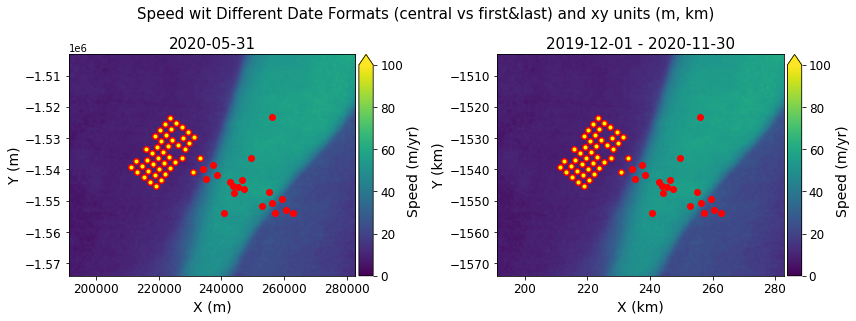

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4.5))
for ax, units, midDate in zip(axes, ['m', 'km'], [True, False]):
    myVelRemote.displayVel(ax=ax, units=units, midDate=midDate)
    myCVPts.plotAllCVLocs(ax=ax, units=units, color='red', marker='o')  # Show all points
    myCVPts.plotVRangeCVLocs(0, 20, ax=ax, units=units, color='yellow') # Over plot slow points
fig.suptitle('Speed wit Different Date Formats (central vs first&last) and xy units (m, km) ', fontsize=15)
fig.tight_layout()

## Interpolate Map to Cal/Val Points

In [12]:
vx20, vy20, iGood = myCVPts.vRangeData(myVelRemote, 0, 20)  # Values less than 20
vx, vy, iGood = myCVPts.vAllData(myVelRemote)  # All values

# Evaluate Data

Differences between the cal/val points ($v_x$ and $v_y$) and the points interpolated from the velocity map ($u_x$ and $u_y$) can be displayed as point plots and histograms as follows:

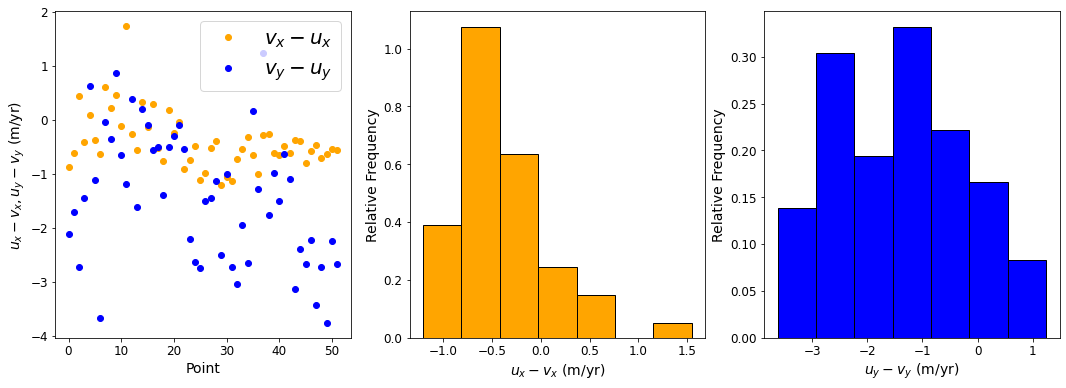

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axPoints = myCVPts.plotVRangeCVDiffs(myVelRemote, 0, 50, ax=axes[0], xColor='orange', marker='o', legendKwargs={'loc': 'upper right', 'fontsize': 20})
axesH = myCVPts.plotVRangeHistDiffs(myVelRemote, 0, 50, xColor='orange', axes=axes[1:], bins=7)

## Velocity Series

In the above examples, only a single velocity product was used. Using `nisarVelSeries` class in place of the `nisarVel` several products can be read. 

In [14]:
myCogs = [httpName.replace('19.12', f'{x}.12').replace('Dec19', f'Dec{x}').replace('Nov20', f'Nov{x+1}') for x in range(14, 20)]
myVelSeries = nisar.nisarVelSeries()
myVelSeries.readSeriesFromTiff(myCogs, url=True, readSpeed=False)
myVelSeries.subSetVel(cvBounds) # Apply subset

This is similar to the single layer case except we provide a list of urls. Most functions will automatically load the data in the subset without explicitly downloading. This works well for a single layer, but for multiple layers it could trigger the data being re-downloaded on each operation, which could slow performance greatly. As a result, it works well to force a download to local variables with the `loadRemote` method.

The velocity series work the same way as the single velocity products, except in some cases a date needs to be specified to select a layer and the method `displayVelForDate` is used. For example to plot the 2018 map the procedure would be.

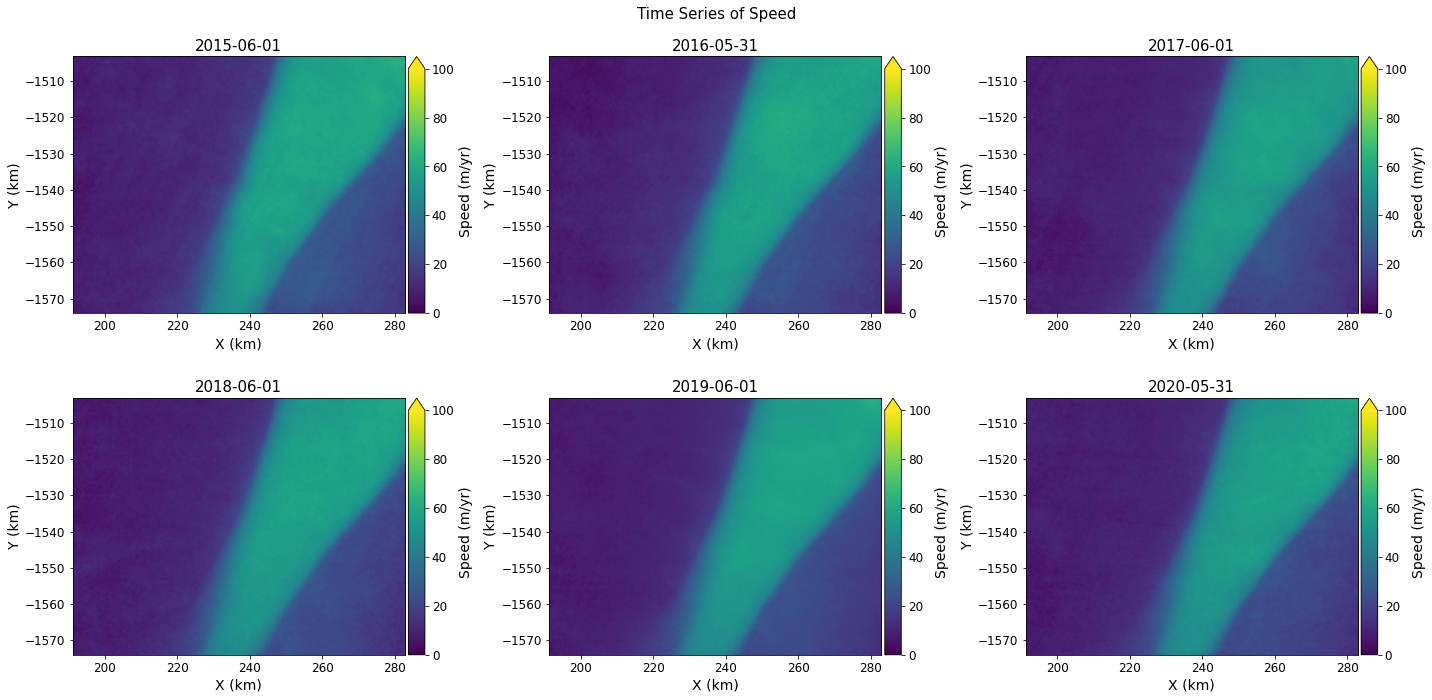

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for date, ax in zip(myVelSeries.time, axes.flatten()):
    myVelSeries.displayVelForDate(date, ax=ax, units='km')
fig.suptitle('Time Series of Speed', fontsize=15)
fig.tight_layout()

## Operations on Velocity Series

Various operations can be applied in time and space to the velocity products. For example, at each point, the mean and standard devation along with the number of valid points for velocity time series are computed as:

In [17]:
%%time
#Compute Stats
velMean = myVelSeries.mean()
velSigma = myVelSeries.stdev()
velCount = myVelSeries.numberValid()

CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 38.8 ms


Each result is returned as a velocity series with only 1 time. The results can be plotted by:

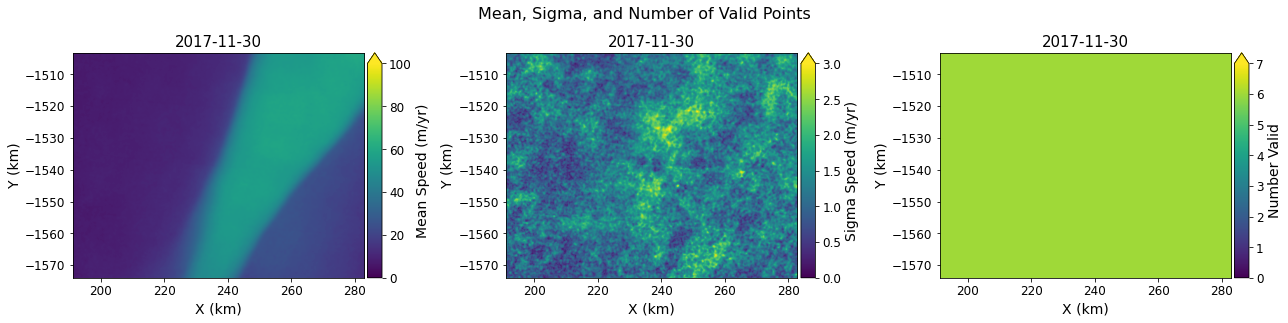

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
velMean.displayVelForDate(ax=axes[0], date=None, units=units, midDate=True, colorBarLabel='Mean Speed (m/yr)')
velSigma.displayVelForDate(ax=axes[1], date=None, units=units, midDate=True, vmin=0, vmax=3, autoScale=False, colorBarLabel='Sigma Speed (m/yr)')
velCount.displayVelForDate(ax=axes[2], date=None, units=units, midDate=True, vmin=0, vmax=7, autoScale=False, colorBarLabel='Number Valid')
fig.suptitle('Mean, Sigma, and Number of Valid Points', fontsize=16)
fig.tight_layout()

The anomalies (value - mean) can be calcuated for each time slices in the series as:

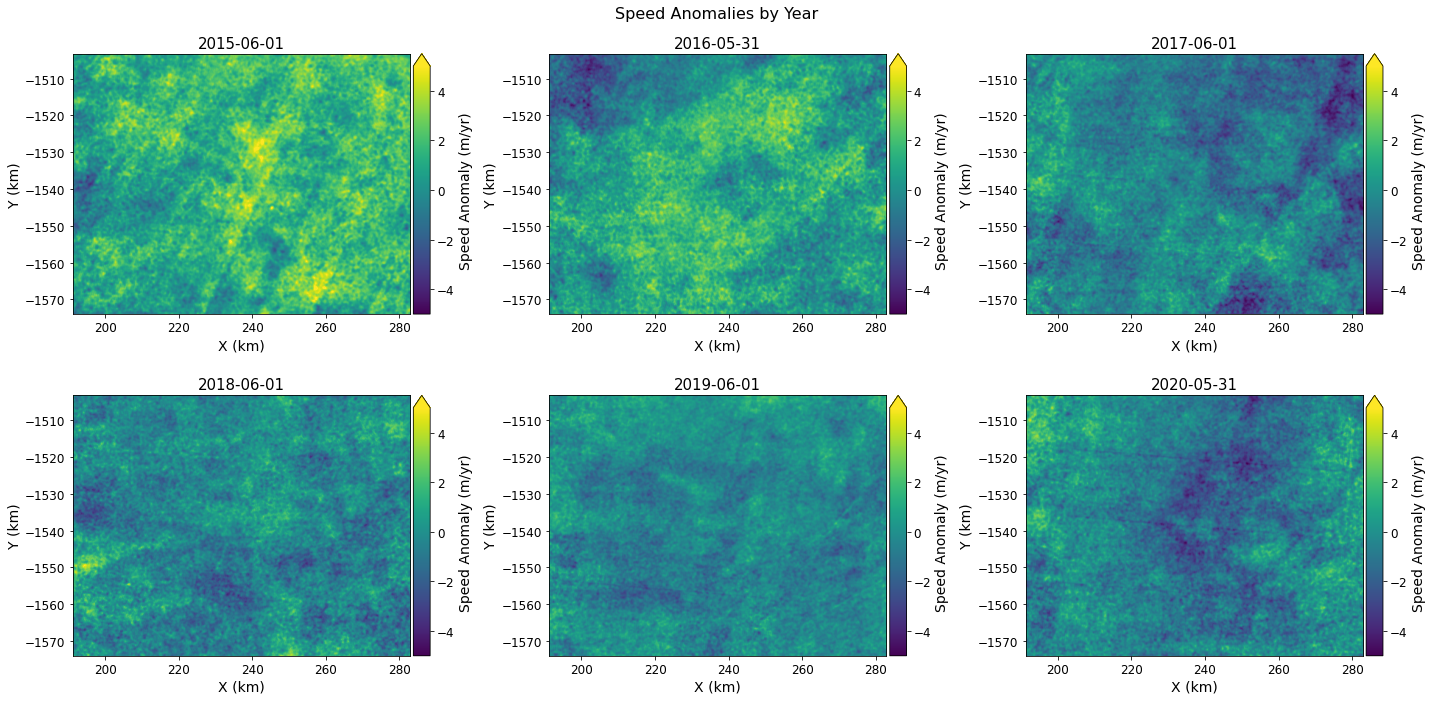

In [19]:
velAnomaly = myVelSeries.anomaly()
# Plot the anomaly for each year
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for date, ax in zip(velAnomaly.time, axes.flatten()):
    velAnomaly.displayVelForDate(date, ax=ax, units='km', vmin=-5, vmax=5, autoScale=False, colorBarLabel='Speed Anomaly (m/yr)')
fig.suptitle('Speed Anomalies by Year', fontsize=16)
fig.tight_layout()


The spatial mean for each time in the series can be computed as: 

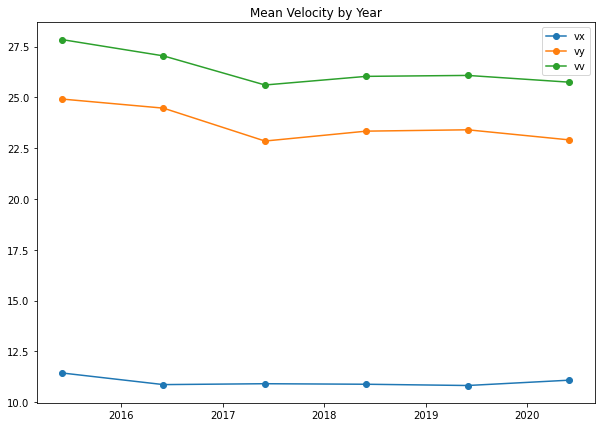

In [20]:
meanXR = myVelSeries.meanXY(returnXR=True) # returnXR=False will return x, y, speed means as nparrays
#
fig, ax = plt.subplots(1, 1, figsize=(10,7))
for band in meanXR.band:
    ax.plot(meanXR.time, meanXR.sel(band=band), '-o', label=band.item())
    ax.set_title('Mean Velocity by Year')
ax.legend();

The standard deviation for the anomalies computed above is evaluated and plotted by year using: 

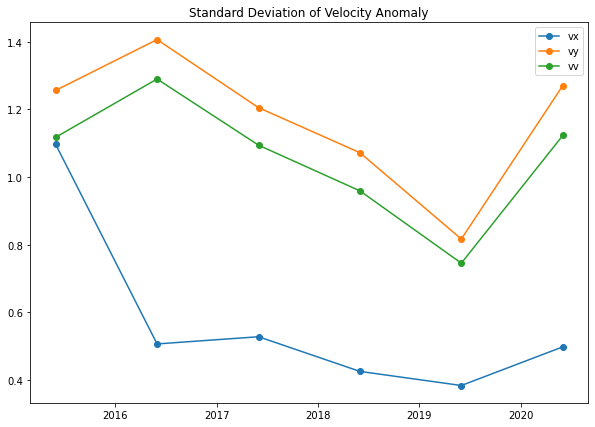

In [21]:
stdevAnomaly = velAnomaly.stdevXY(returnXR=True) # returnXR=False will return x, y, speed means as nparrays
#
fig, ax = plt.subplots(1, 1, figsize=(10,7))
for band in stdevAnomaly.band:
    ax.plot(stdevAnomaly.time, stdevAnomaly.sel(band=band), '-o', label=band.item())
    ax.set_title('Standard Deviation of Velocity Anomaly')
ax.legend();

# Interpolation

In the examples above, the interpolation of the control points is carried out in the instance of `cvPoints`. The next cell shows the interpolation directly. As demonstrated, while the interpolation is carried out in the coordinates of the velocity data, points can be interpolated from any coordinate system with **epsg** code and a choice of km or m as the units (deg assumed for lat/lon).

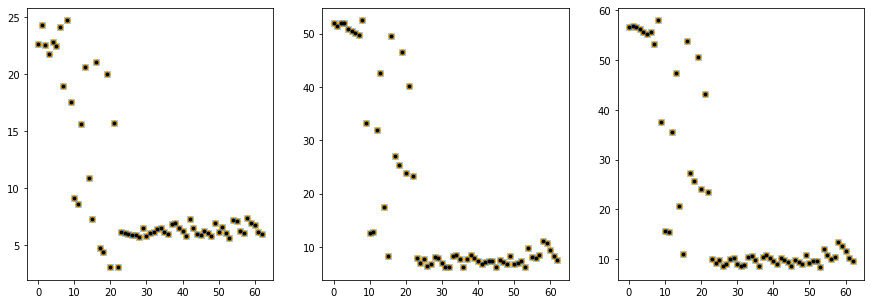

In [22]:
vxm, vym, vvm = myVelSeries.interp(*myCVPts.xyAll(), date='2019-01-01', units='m')  # All values.xyAll(), units='m')  # x,y coordinates are passed in as m
vxkm, vykm, vvkm = myVelSeries.interp(*myCVPts.xyAll(units='km'), date='2019-01-01', units='km')  # All values.xyAll(), units='m')  # x,y coordinates are passed in as m
vxll, vyll, vvll = myVelSeries.interp(myCVPts.lat, myCVPts.lon,  date='2019-01-01', sourceEPSG=4326)
#
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, vComp in zip(axes, [[vxm, vxkm, vxll], [vym, vykm, vyll], [vvm, vvkm, vvll]]):
    for v, m, c in zip(vComp, ['o', 'x', '.'], ['orange', 'dodgerblue', 'k']):
        ax.plot(range(0,len(v)), v, m, color=c)

The results can also be interpolated for each time. In this example, the result is return as an xarray:

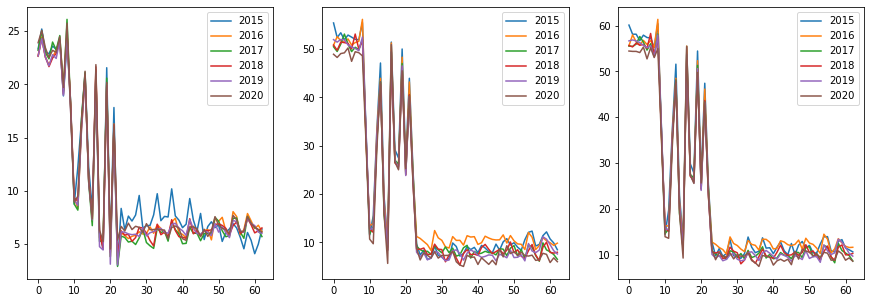

In [23]:
vPts = myVelSeries.interp(*myCVPts.xyAll(), date=None, units='m', returnXR=True)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, band in zip(axes, vPts.band):
    for t in vPts.time:
        year = str(np.datetime64(t.item(0), 'ns'))[0:4]
        ax.plot(vPts.sel(band=band, time=t), label=year)
    ax.legend()